In [68]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
import pandas as pd
import yt
import math
from matplotlib import ticker
from colormap import rgb2hex                         

from mpl_toolkits.axes_grid1.inset_locator import (
    inset_axes, InsetPosition, mark_inset
)

# Figure aesthetics
plt.rc("text", usetex=False)
plt.rc("font", size=12)
plt.rc("axes", titlesize=60)
plt.rcParams.update({
    "legend.fontsize": 12,
    "lines.markersize": 5,
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.2,
    "lines.linewidth": 1.0,
})

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))

aspect = 1.0

# Custom colour palette (red → blue gradient)
ncol = 5
red  = np.array([254,   0,   2], dtype=int)
blue = np.array([  3,   2, 252], dtype=int)

c1 = np.linspace(red[0],  blue[0],  ncol, dtype=int)
c2 = np.linspace(red[1],  blue[1],  ncol, dtype=int)
c3 = np.linspace(red[2],  blue[2],  ncol, dtype=int)

colors = [rgb2hex(r, g, b) for r, g, b in zip(c1, c2, c3)][::-1]

def preprocess_data(Z, eps=1e-8):
    Z_proc = np.empty_like(Z, dtype=np.float64)
    Z_proc[:, 0] = np.log(Z[:, 0]) 
    Z_clipped = np.clip(Z[:, 1:], eps, 1.0 - eps)
    Z_proc[:, 1:] = np.log(Z_clipped / (1.0 - Z_clipped))  # logit
    return Z_proc

def inverse_preprocess_data(Z_proc):
    Z = np.empty_like(Z_proc, dtype=np.float64)
    Z[:, 0] = np.exp(Z_proc[:, 0])
    Z[:, 1:] = 1.0 / (1.0 + np.exp(-Z_proc[:, 1:]))  # sigmoid
    return Z

In [69]:
# Data loader
def load_single_r_data(folder_r):
    ef_file = os.path.join(folder_r, "Ef.txt")
    E_data = np.loadtxt(ef_file)

    folder_name = os.path.basename(folder_r)
    i_r = int(folder_name[1:])
    r_val = 0.1 * i_r

    pre_energy  = E_data[:, 0] + E_data[:, 1] + E_data[:, 2]
    post_energy = E_data[:, 3] + E_data[:, 4] + E_data[:, 5]
    E_rot       = E_data[:, 1] + E_data[:, 2]
    E_rot_prime = E_data[:, 4] + E_data[:, 5]

    epsilon_tr          = E_data[:, 0] / pre_energy
    epsilon_tr_prime    = E_data[:, 3] / post_energy
    epsilon_rot_1       = E_data[:, 1] / E_rot
    epsilon_rot_1_prime = E_data[:, 4] / E_rot_prime

    r_column = np.full_like(epsilon_tr, r_val)
    return np.column_stack((r_column, epsilon_tr, epsilon_rot_1, epsilon_tr_prime, epsilon_rot_1_prime))

def load_all_data(base_dir, r_range=range(1, 13)):
    all_data = []
    for i in r_range:
        folder = os.path.join(base_dir, f"r{i:02d}")
        all_data.append(load_single_r_data(folder))
    return np.vstack(all_data)

In [70]:
# GMM BIC Selection
def find_best_gmm_bic(Z_scaled, max_components=40, random_state=42, covariance_type='full'):
    lowest_bic = np.inf
    best_n = None
    bics = []

    for n in range(1, max_components + 1):
        gmm = GaussianMixture(n_components=n, covariance_type=covariance_type, random_state=random_state)
        gmm.fit(Z_scaled)
        bic = gmm.bic(Z_scaled)
        bics.append(bic)
        if bic < lowest_bic:
            best_n = n
            lowest_bic = bic

    print(f"Best n_components: {best_n}, BIC: {lowest_bic:.2f}")
    return best_n, bics

In [71]:
# GMM Sampling
def conditional_gmm_sample_scaled(gmm, x_scaled, D_x=3, D_y=2):
    weights, means, covs = gmm.weights_, gmm.means_, gmm.covariances_
    M = len(weights)

    alphas = np.array([
        weights[m] * multivariate_normal.pdf(x_scaled, mean=means[m][:D_x], cov=covs[m][:D_x, :D_x])
        for m in range(M)
    ])
    alphas /= np.sum(alphas) if np.sum(alphas) > 1e-30 else np.ones(M) / M
    m = np.random.choice(np.arange(M), p=alphas)

    mu_x, mu_y = means[m][:D_x], means[m][D_x:]
    Sigma_xx = covs[m][:D_x, :D_x]
    Sigma_xy = covs[m][:D_x, D_x:]
    Sigma_yx = covs[m][D_x:, :D_x]
    Sigma_yy = covs[m][D_x:, D_x:]

    mu_cond = mu_y + Sigma_yx @ np.linalg.inv(Sigma_xx) @ (x_scaled - mu_x)
    Sigma_cond = Sigma_yy - Sigma_yx @ np.linalg.inv(Sigma_xx) @ Sigma_xy
    return np.random.multivariate_normal(mean=mu_cond, cov=Sigma_cond)

def sample_conditionals(gmm, scaler, r, e_tr, e_r1, n_samples=1):
    samples = []
    for _ in range(n_samples):
        z_unscaled = np.array([r, e_tr, e_r1, 0.0, 0.0])
        z_proc = preprocess_data(z_unscaled.reshape(1, -1))
        z_scaled = scaler.transform(z_proc)
        y_scaled = conditional_gmm_sample_scaled(gmm, z_scaled[0, :3])
        z_scaled[0, 3:] = y_scaled
        z_proc_new = scaler.inverse_transform(z_scaled)
        z_unscaled_new = inverse_preprocess_data(z_proc_new)
        samples.append(z_unscaled_new[0, 3:])
    return np.array(samples)

In [72]:
# GMM Validation
def run_gmm_validation(base_dir, gmm, scaler, r_input=0.5, n_samples=20000):
    i_r = int(round(r_input * 10))
    folder_r = os.path.join(base_dir, f"r{i_r:02d}")
    Z_real = load_single_r_data(folder_r)

    # Use true epsilon_tr, epsilon_r1 as inputs
    epsilon_tr_vals = Z_real[:, 1]
    epsilon_r1_vals = Z_real[:, 2]
    true_epsilon_tr_prime = Z_real[:, 3]
    true_epsilon_r1_prime = Z_real[:, 4]

    # Sample subset if data is more than needed
    total = len(Z_real)
    if total > n_samples:
        idx = np.random.choice(total, size=n_samples, replace=False)
    else:
        idx = np.arange(total)

    predictions = []
    for i in idx:
        etr = epsilon_tr_vals[i]
        er1 = epsilon_r1_vals[i]
        pred = sample_conditionals(gmm, scaler, r_input, etr, er1, n_samples=1)[0]
        predictions.append(pred)
    predictions = np.array(predictions)

    # Ground truth for same indices
    etr_prime_real = true_epsilon_tr_prime[idx]
    er1_prime_real = true_epsilon_r1_prime[idx]
    etr_prime_pred = predictions[:, 0]
    er1_prime_pred = predictions[:, 1]

    # Plot comparison
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].hist(etr_prime_real, bins=100, alpha=0.6, label='True')
    axs[0].hist(etr_prime_pred, bins=100, alpha=0.6, label='GMM')
    axs[0].set_title(r"$\epsilon_{tr}'$")
    axs[0].legend()

    axs[1].hist(er1_prime_real, bins=100, alpha=0.6, label='True')
    axs[1].hist(er1_prime_pred, bins=100, alpha=0.6, label='GMM')
    axs[1].set_title(r"$\epsilon_{r1}'$")
    axs[1].legend()

    plt.suptitle(f"GMM Validation vs Ground Truth for r = {r_input}")
    plt.tight_layout()
    plt.show()

    stats_df = pd.DataFrame({
        "Stat": ["Mean", "Std Dev"],
        "E_tr'_real": [np.mean(etr_prime_real), np.std(etr_prime_real)],
        "E_tr'_pred": [np.mean(etr_prime_pred), np.std(etr_prime_pred)],
        "E_r1'_real": [np.mean(er1_prime_real), np.std(er1_prime_real)],
        "E_r1'_pred": [np.mean(er1_prime_pred), np.std(er1_prime_pred)]
    })

    return stats_df

In [73]:
# Load and preprocess data
base_dir = "/home/muhammed/Documents/Thesis/New Simulations/GMM/AR20"
bigZ = load_all_data(base_dir)

# Preprocess
bigZ_proc = preprocess_data(bigZ)
scaler = StandardScaler().fit(bigZ_proc)
bigZ_scaled = scaler.transform(bigZ_proc)

In [75]:
print(scaler.mean_)
print(scaler.scale_)

[-0.63698389 -0.71145079  0.00253621 -0.2661104   0.00968865]
[0.72365841 1.3531477  1.8060068  1.20982009 1.81067761]


In [ ]:
# optimize GMM components based on BIC
n_best, bics = find_best_gmm_bic(bigZ_scaled, max_components=40)

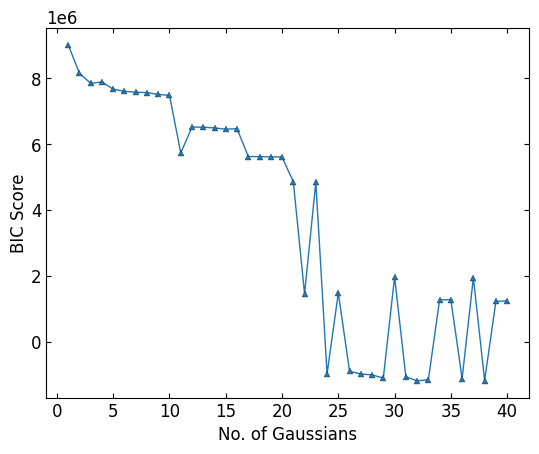

In [ ]:
fig,ax = plt.subplots();
ax.plot(range(1, 41), bics, marker='^')
ax.set_xlabel("No. of Gaussians")
ax.set_ylabel("BIC Score",labelpad=+2)
ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.show()

In [13]:
gmm_model = GaussianMixture(n_components=37, covariance_type='full', random_state=42)
gmm_model.fit(bigZ_scaled)

GaussianMixture(n_components=37, random_state=42)

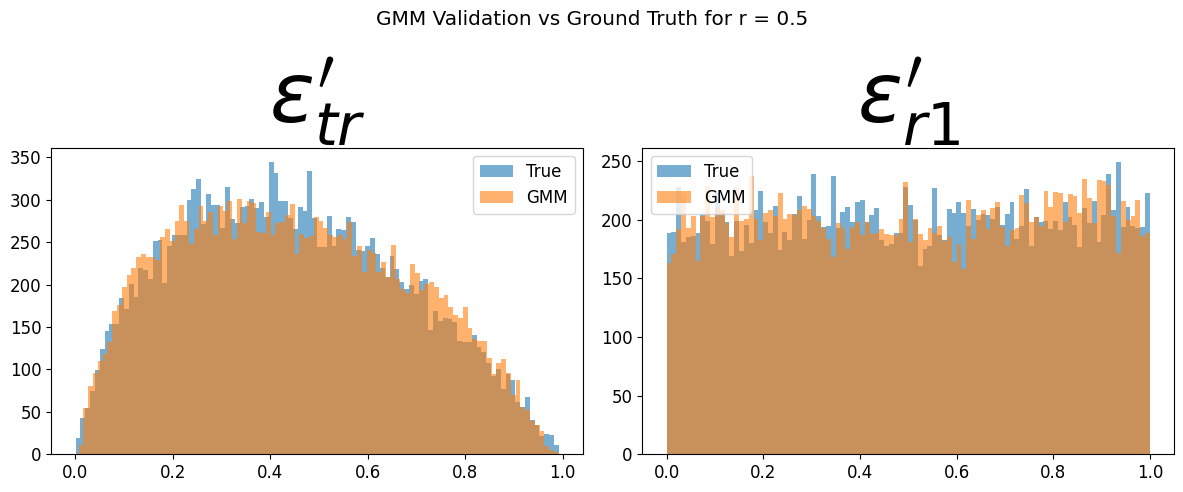

      Stat  E_tr'_real  E_tr'_pred  E_r1'_real  E_r1'_pred
0     Mean    0.443756    0.447283    0.503863    0.504573
1  Std Dev    0.226331    0.230905    0.288748    0.290817


In [74]:
stats = run_gmm_validation(base_dir, gmm_model, scaler, r_input=0.5, n_samples=20000)
print(stats)

In [16]:
import numpy as np
import os

# 1. Load the REAL data using your existing loader function
# (Ensure this function is defined as in your notebook)
base_dir = "/home/muhammed/Documents/Thesis/New Simulations/GMM/AR20"
r_input = 0.5
i_r = int(round(r_input * 10))
folder_r = os.path.join(base_dir, f"r{i_r:02d}")

# This returns: [r, epsilon_tr, epsilon_rot_1, epsilon_tr', epsilon_rot_1']
Z_real = load_single_r_data(folder_r) 

# 2. Extract ONLY the input epsilons (columns 1 and 2)
# We need e_tr and e_r1
inputs = Z_real[:, 1:3] 

# 3. Sanity Check: Ensure everything is between 0 and 1
print(f"Max input value: {np.max(inputs)}")
if np.max(inputs) > 1.0:
    print("WARNING: Data is still not normalized!")
else:
    print("Data looks valid (0.0 - 1.0). Saving...")

# 4. Save to text file for Fortran
np.savetxt("inputs_r05.txt", inputs, fmt='%.10e')

Max input value: 0.9999726530296661
Data looks valid (0.0 - 1.0). Saving...


In [78]:
import numpy as np

def export_conditional_gmm_npz(gmm, scaler, out_path="gmm_cond_5d_dx3_dy2.npz", D_x=3, D_y=2, jitter=1e-12):
    w = gmm.weights_.astype(np.float64)                  # (M,)
    means = gmm.means_.astype(np.float64)               # (M,5)
    covs = gmm.covariances_.astype(np.float64)          # (M,5,5) for covariance_type='full'
    M = w.shape[0]

    inv_xx = np.empty((M, D_x, D_x), dtype=np.float64)
    logdet_xx = np.empty((M,), dtype=np.float64)
    A = np.empty((M, D_y, D_x), dtype=np.float64)
    mu_y = means[:, D_x:D_x+D_y].copy()
    L = np.empty((M, D_y, D_y), dtype=np.float64)

    for m in range(M):
        S = covs[m]
        Sxx = S[:D_x, :D_x]
        Sxy = S[:D_x, D_x:D_x+D_y]
        Syx = S[D_x:D_x+D_y, :D_x]
        Syy = S[D_x:D_x+D_y, D_x:D_x+D_y]

        # inv and logdet of Sxx
        sign, ld = np.linalg.slogdet(Sxx)
        if sign <= 0:
            # numerical fix
            Sxx = Sxx + np.eye(D_x)*jitter
            sign, ld = np.linalg.slogdet(Sxx)
        invSxx = np.linalg.inv(Sxx)

        inv_xx[m] = invSxx
        logdet_xx[m] = ld

        A[m] = Syx @ invSxx  # (2,3)

        # Sigma_cond = Syy - Syx invSxx Sxy
        Scond = Syy - A[m] @ Sxy
        # ensure SPD
        Scond = 0.5*(Scond + Scond.T)
        # jitter if needed
        try:
            L[m] = np.linalg.cholesky(Scond)
        except np.linalg.LinAlgError:
            L[m] = np.linalg.cholesky(Scond + np.eye(D_y)*max(jitter, 1e-10))
            
        print(L[m])

    scaler_mean = scaler.mean_.astype(np.float64)        # (5,)
    scaler_scale = scaler.scale_.astype(np.float64)      # (5,)

    np.savez(out_path,
             weights=w,
             means=means,
             inv_xx=inv_xx,
             logdet_xx=logdet_xx,
             A=A,
             mu_y=mu_y,
             L=L,
             scaler_mean=scaler_mean,
             scaler_scale=scaler_scale)
    print(f"Saved conditional-GMM package to: {out_path}")

# Example usage after training:
export_conditional_gmm_npz(gmm_model, scaler, "gmm_cond_AR20.npz")

[[0.6377603  0.        ]
 [0.05461341 0.64839007]]
[[0.48750191 0.        ]
 [0.12093123 0.18442113]]
[[ 0.78198809  0.        ]
 [-0.0208416   0.46929997]]
[[ 0.88103704  0.        ]
 [-0.00461868  1.02589842]]
[[ 0.8388513   0.        ]
 [-0.01302609  1.35086779]]
[[0.80537439 0.        ]
 [0.00664134 0.26253224]]
[[0.36181177 0.        ]
 [0.15525858 0.54597587]]
[[ 0.86282644  0.        ]
 [-0.10275536  1.12188552]]
[[0.82425937 0.        ]
 [0.16920878 0.58936552]]
[[ 0.894542    0.        ]
 [-0.00697968  1.21232784]]
[[ 0.92280512  0.        ]
 [-0.00417037  0.91121324]]
[[ 0.81251789  0.        ]
 [-0.00219956  0.55943195]]
[[ 8.96007896e-01  0.00000000e+00]
 [-6.50186663e-04  5.82779911e-01]]
[[ 0.94177297  0.        ]
 [-0.002614    0.66785483]]
[[ 0.82501188  0.        ]
 [-0.11070962  0.84884264]]
[[0.90388571 0.        ]
 [0.00225888 0.88318059]]
[[ 0.84477358  0.        ]
 [-0.00564015  0.38375805]]
[[ 0.75445925  0.        ]
 [-0.01199571  0.37377402]]
[[1.4289821  0.   

In [79]:
import numpy as np

# Load the SAME .npz file you converted to .bin
data = np.load("gmm_cond_AR20.npz")

w = data["weights"]
means = data["means"]
L = data["L"]
M = len(w)

print("================ PYTHON TRUTH ================")
print(f"M (Components): {M}")

# Component 0 (Fortran 1)
print("--- Component 1 (Python idx 0) ---")
print(f"Weight: {w[0]:.8e}")
print(f"Mean (first 3): {means[0, :3]}")
print(f"L Matrix (Row 0): {L[0, 0, :]}")
print(f"L Matrix (Row 1): {L[0, 1, :]}")

# Middle Component
if M > 10:
    i = M // 2 
    # Note: integer division in Python corresponds to index i 
    # Fortran index will be i (because of 1-based vs 0-based floor logic difference, usually close enough for check)
    # Actually, Fortran i = M/2. If M=37, Fortran=18. Python index 17.
    idx_py = (M // 2) - 1 # Adjust to match Fortran integer division of 1-based index roughly
    # Let's just match the Fortran index 'i' logic:
    # Fortran i = M/2 (integer div). 
    # If M=37, i=18. This is Python index 17.
    idx_py = (M // 2) 
    # Wait, Fortran 18 is Python 17. 
    # If M=37, M/2 = 18. Python index 17.
    # Actually, let's just look at the last one to be sure.

# Last Component (Fortran M)
print(f"--- Component {M} (Python idx {M-1}) ---")
print(f"Weight: {w[-1]:.8e}")
print(f"Mean (first 3): {means[-1, :3]}")
print("==============================================")

================ PYTHON TRUTH ================
M (Components): 37
--- Component 1 (Python idx 0) ---
Weight: 4.10775048e-05
Mean (first 3): [1.01193333 0.10639464 2.04604532]
L Matrix (Row 0): [0.6377603 0.       ]
L Matrix (Row 1): [0.05461341 0.64839007]
--- Component 37 (Python idx 36) ---
Weight: 8.33047764e-02
Mean (first 3): [ 0.3873498   0.20936726 -0.00322712]


In [55]:
import numpy as np

def fix_gmm_binary(npz_path="gmm_cond_AR20.npz", bin_path="gmm_cond_AR20.bin"):
    try:
        data = np.load(npz_path)
    except FileNotFoundError:
        print(f"Error: Could not find {npz_path}. Please check the path.")
        return

    print(f"Loading {npz_path}...")
    with open(bin_path, "wb") as f:
        # Header: M, D
        M = data["weights"].shape[0]
        D = data["means"].shape[1]
        np.array([M, D], dtype=np.int32).tofile(f)

        # WRITE ALL ARRAYS IN FORTRAN (COLUMN-MAJOR) ORDER
        # This fixes the transposed matrix issue that causes the variance collapse
        data["weights"].astype(np.float64).flatten(order='F').tofile(f)
        data["means"].astype(np.float64).flatten(order='F').tofile(f)
        data["inv_xx"].astype(np.float64).flatten(order='F').tofile(f)
        data["logdet_xx"].astype(np.float64).flatten(order='F').tofile(f)
        data["A"].astype(np.float64).flatten(order='F').tofile(f)
        data["mu_y"].astype(np.float64).flatten(order='F').tofile(f)
        data["L"].astype(np.float64).flatten(order='F').tofile(f)
        
        # SCALERS
        data["scaler_mean"].astype(np.float64).flatten(order='F').tofile(f)
        data["scaler_scale"].astype(np.float64).flatten(order='F').tofile(f)

    print(f"SUCCESS: Fixed {bin_path} generated with Fortran ordering.")

# Run this immediately
fix_gmm_binary()

Loading gmm_cond_AR20.npz...
SUCCESS: Fixed gmm_cond_AR20.bin generated with Fortran ordering.


AttributeError: 'GaussianMixture' object has no attribute 'weights'

In [ ]:
# KL Divergence to establish GMM discretization
from scipy.special import gamma
from scipy.integrate import simps

# Parameters
zeta_tr = 4
zeta_rot = 4
eps_tr = np.linspace(1e-5, 1 - 1e-5, 500)
theta_vals = np.linspace(0.1, 1.3, 300)
theta_refs = [0.2, 0.4, 0.6, 1.0]

# Distribution function
def feq_eps(eps_tr, theta):
    Ttr = 1.0
    Trot = Ttr / theta
    norm = gamma((zeta_tr + zeta_rot) / 2) / (gamma(zeta_tr / 2) * gamma(zeta_rot / 2))
    density = (eps_tr**(zeta_tr / 2 - 1)) * ((1 - eps_tr)**(zeta_rot / 2 - 1))
    scale = (eps_tr / Ttr + (1 - eps_tr) / Trot)**(-(zeta_tr + zeta_rot) / 2)
    return norm * density * scale

# Normalize a PDF
def normalize(fx, x):
    return fx / simps(fx, x)

# KL divergence
def kl_div(f, g, x):
    mask = (f > 0) & (g > 0)
    return simps(f[mask] * np.log(f[mask] / g[mask]), x[mask])

fig,ax = plt.subplots()
# Compute KL curves for each reference
for i, theta_ref in enumerate(theta_refs):
    f_ref = normalize(feq_eps(eps_tr, theta_ref), eps_tr)
    kl_vals = []
    for theta in theta_vals:
        f_theta = normalize(feq_eps(eps_tr, theta), eps_tr)
        kl_vals.append(kl_div(f_ref, f_theta, eps_tr))
    ax.plot(theta_vals, kl_vals, label=fr'KL($f_{{{theta_ref}}} \| f_\theta$)', color=colors[i])
    
# Draw Delta(theta) = 0.1 brackets for each reference theta
for i, theta_ref in enumerate(theta_refs):
    y_pos = 0.05 + 0.07 * i  
    left = theta_ref - 0.05
    right = theta_ref + 0.05
    ax.plot([left, right], [y_pos, y_pos], color='gray', lw=1)
    ax.plot([left, left], [y_pos - 0.01, y_pos + 0.01], color='gray', lw=1)
    ax.plot([right, right], [y_pos - 0.01, y_pos + 0.01], color='gray', lw=1)

# Annotate only one with Delta(theta) = 0.1
ax.text(0.53, 0.01 + 0.055 * len(theta_refs), r'$\Delta \theta = 0.1$', fontsize=8, color='gray')
#plt.axvline(1.0, color='gray', linestyle='--', linewidth=1.0)
#plt.axvline(0.6, color='gray', linestyle='--', linewidth=1.0)
#plt.axvline(0.4, color='gray', linestyle='--', linewidth=1.0)
#plt.axvline(0.2, color='gray', linestyle='--', linewidth=1.0)
# Labels, legend, layout
ax.set_xlabel(r'$\theta$', fontsize=12)
ax.set_ylabel('KL divergence', fontsize=12)
ax.set_xlim([0.05,1.35])
ax.set_ylim([-0.1,2.0])
xval, yval = ax.get_xlim(), ax.get_ylim()
aspect= 1
xrange = xval[1]-xval[0];
yrange = yval[1]-yval[0];
ax.set_aspect(aspect*(xrange/yrange), adjustable='box')
ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)
legend1 = ax.legend(
    loc='upper right',
    fontsize=9,
    frameon=True,
)
legend1.get_frame().set_edgecolor('black')
legend1.get_frame().set_linewidth(0.8)
ax.add_artist(legend1)

#ax.xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])

#ax.grid(True, linestyle='--', alpha=0.5)
mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
#save_path = os.path.join(save_dir, "KLD.png")
#plt.savefig(save_path, format='png', bbox_inches='tight')
plt.show()

In [81]:
# Scattering angle Chi model
from scipy.optimize import curve_fit
import re

# Define 4th-degree polynomial
def poly4(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

def load_chi_data(filepath):
    try:
        data = np.loadtxt(filepath)
        return data[:, 1] / np.pi  # Normalize chi to [0,1]
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

def fit_polynomial(x_vals, bins=100):
    # Compute histogram
    hist, bin_edges = np.histogram(x_vals, bins=bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # Normalize by number of samples
    bin_width = bin_edges[1] - bin_edges[0]
    prob_density = hist / (len(x_vals) * bin_width)

    try:
        coeffs, _ = curve_fit(poly4, bin_centers, prob_density, maxfev=5000)
        return coeffs
    except Exception as e:
        print(f"Curve fitting failed: {e}")

In [82]:
# Paths and parameters
root_dir = "/home/muhammed/Documents/Thesis/New Simulations/Alpha"
aspect_ratios = [10, 15, 20, 25, 30, 40]   # AR = dir / 10
alphas = [60, 65, 70, 75, 80, 85, 90, 95, 100] # α = dir / 100

# Storage for coefficients
elastic_coeffs = {}    # AR -> [a, b, c, d, e]
delta_p_data = []      # list of tuples: (x, AR, alpha, delta_p)

# For elastic model design matrix
elastic_x_data = []
elastic_AR_data = []
elastic_p_data = []
x_vals = np.linspace(0, 1, 100)

# Fit elastic model from Alpha/100
for ar in aspect_ratios:
    path = os.path.join(root_dir, "100", str(ar), "chi.txt")
    chi_data = load_chi_data(path)
    
    if chi_data is not None:
        coeffs = fit_polynomial(chi_data)
        if coeffs is not None:
            elastic_coeffs[ar] = coeffs
            p_vals = np.polyval(coeffs, x_vals)

            # data points for design matrix regression
            elastic_x_data.extend(x_vals)
            elastic_AR_data.extend([ar / 10.0] * len(x_vals))
            elastic_p_data.extend(p_vals)

In [83]:
# Fit inelastic and compute delta_p
for alpha in alphas:
    if alpha == 100: continue  # skip elastic case
    for ar in aspect_ratios:
        path = os.path.join(root_dir, str(alpha), str(ar), "chi.txt")
        chi_data = load_chi_data(path)
        if chi_data is None: continue

        inelastic_coeffs = fit_polynomial(chi_data)
        if inelastic_coeffs is None or ar not in elastic_coeffs: continue

        # Compute delta_p polynomial coefficients
        dp_coeffs = [in_ - el_ for in_, el_ in zip(inelastic_coeffs, elastic_coeffs[ar])]

        # Generate delta p(x) data for design matrix
        x_vals = np.linspace(0, 1, 100)
        dp_vals = poly4(x_vals, *dp_coeffs)
        for x, dp in zip(x_vals, dp_vals):
            delta_p_data.append((x, ar/10.0, alpha/100.0, dp))

# Convert to numpy arrays for modeling
delta_p_data = np.array(delta_p_data)
x_data, AR_data, alpha_data, dp_data = delta_p_data.T

In [84]:
def phi(alpha, beta=1.0):

    return 1.0 - alpha**beta

def build_design_matrix(x_data, AR_data, alpha_data, dp_data,
                        K=4, M=2, N=2, beta=1.0):
    R = len(x_data)
    if not (len(AR_data) == R and len(alpha_data) == R and len(dp_data) == R):
        raise ValueError("All input arrays must have the same length R.")

    # Number of columns in design matrix
    num_cols = (K+1)*(M+1)*(N+1)

    # Allocate
    X = np.zeros((R, num_cols), dtype=float)
    y = np.zeros(R, dtype=float)

    # Precompute phi(alpha)
    phi_vals = [phi(a, beta=beta) for a in alpha_data]

    for r in range(R):
        x_r  = x_data[r]
        AR_r = AR_data[r]
        ph_r = phi_vals[r]

        # Fill row r of the design matrix
        col_index = 0
        for m in range(M+1):     # 0..M
            for n in range(N+1): # 0..N
                for k in range(K+1): # 0..K
                    bf = (AR_r**m) * (ph_r**n) * (x_r**k)
                    X[r, col_index] = bf
                    col_index += 1

        # The target is dp_data
        y[r] = dp_data[r]

    return X, y

In [85]:
K, M, N     = 4, 2, 2         
beta_choice = 0.5        
X, y = build_design_matrix(
    x_data, AR_data, alpha_data, dp_data,
    K=K, M=M, N=N, beta=beta_choice
)
a_vec, residuals, rank, svals = np.linalg.lstsq(X, y, rcond=None)
print("Coefficients shape:", a_vec.shape)
print("Residual sum of squares:", residuals)
a_reshaped = a_vec.reshape((M+1, N+1, K+1), order='C')
print("Coefficients shape: ", a_reshaped.shape)

Coefficients shape: (45,)
Residual sum of squares: [0.40485799]
Coefficients shape:  (3, 3, 5)


In [86]:
def build_elastic_design_matrix(x_data, AR_data, p_data, K=4, M=2):
    R = len(x_data)
    assert R == len(AR_data) == len(p_data)

    num_cols = (M + 1) * (K + 1)
    X = np.zeros((R, num_cols), dtype=float)
    y = np.zeros(R, dtype=float)

    for r in range(R):
        x = x_data[r]
        AR = AR_data[r]
        col_idx = 0
        for m in range(M + 1):
            for k in range(K + 1):
                X[r, col_idx] = (AR ** m) * (x ** k)
                col_idx += 1
        y[r] = p_data[r]
    
    return X, y

X_elastic, y_elastic = build_elastic_design_matrix(
    np.array(elastic_x_data),
    np.array(elastic_AR_data),
    np.array(elastic_p_data),
    K=4, M=2
)
a_vec_elastic, residuals_elastic, _, _ = np.linalg.lstsq(X_elastic, y_elastic, rcond=None)
a_elastic_reshaped = a_vec_elastic.reshape((M + 1, K + 1), order='C')

print("Coefficients shape:", a_vec_elastic.shape)
print("Residual sum of squares:", residuals_elastic)
print("Coefficients shape: ", a_elastic_reshaped.shape)

Coefficients shape: (15,)
Residual sum of squares: [0.16234768]
Coefficients shape:  (3, 5)


In [87]:
def P_elastic(x, AR, a_elastic_reshaped, M=2, K=4):
    x = np.atleast_1d(x)
    P = np.zeros_like(x, dtype=float)

    for m in range(M + 1):
        for k in range(K + 1):
            coeff = a_elastic_reshaped[m, k]
            P += coeff * (AR ** m) * (x ** k)

    return P if x.size > 1 else P[0]

def delta_p_model(x, AR, alpha, a_reshaped, M, N, K, beta=1.0):
    # Ensure x is a NumPy array for vectorized evaluation
    x_arr = np.atleast_1d(x)
    
    # compute phi(alpha)
    phi_val = 1.0 - alpha**beta
    
    # We'll accumulate results in an array of same shape as x_arr
    s = np.zeros_like(x_arr, dtype=float)
    
    # Triple nested loops for m=0..M, n=0..N, k=0..K
    for m in range(M+1):
        for n in range(N+1):
            for k_ in range(K+1):
                coeff = a_reshaped[m, n, k_] 
                s += coeff * (AR**m) * (phi_val**n) * (x_arr**k_)
    
    # s now holds Delta p
    return s if x_arr.size > 1 else s[0]

def p_chi_AR_alpha (chi, AR, alpha):
    P_alpha1 = P_elastic(chi, AR, a_elastic_reshaped)
    #P_alpha1 = enforce_non_negativity(chi, P_alpha1)
    delP = delta_p_model(chi, AR, alpha, a_reshaped, M, N, K, beta=0.5)
    P_chi = P_alpha1 + delP
    return P_chi

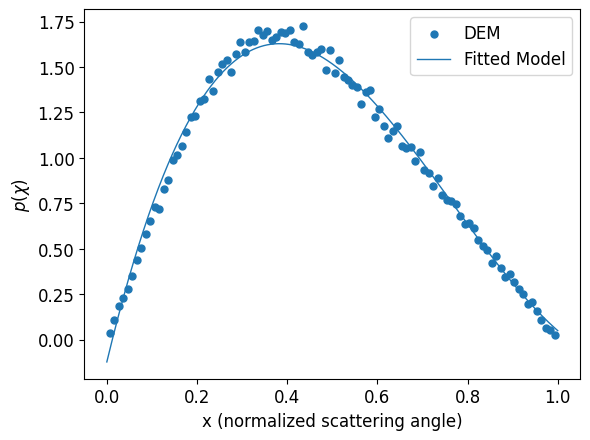

In [88]:
# Example usage
chi_test = np.linspace(0, 1, 1000)
AR = 2.0
alpha = 0.95
p_chi_pred = p_chi_AR_alpha (chi_test, AR, alpha)

def load_and_process_Edata(file_path):
    chi_data = np.loadtxt(file_path)
    chi = chi_data[:, 1]/np.pi
    return chi

chi_DEM = load_and_process_Edata('/home/muhammed/Documents/Thesis/New Simulations/Alpha/95/20/chi.txt')
hist_data, bin_edges = np.histogram(chi_DEM, bins=100)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

plt.scatter(bin_centers, 100*hist_data/len(chi_DEM), label=f'DEM')
plt.plot(chi_test, p_chi_pred, label="Fitted Model")
#plt.scatter(x_test, y2, label="0.9", alpha=0.5)
plt.xlabel("x (normalized scattering angle)")
plt.ylabel(r"$p(\chi)$")
#plt.title(f"Delta p for AR={AR_test}, alpha={alpha_test}")
plt.legend()
plt.show()

In [89]:
def print_elastic_chi_coeffs(a_elastic_reshaped):
    M, K = a_elastic_reshaped.shape[0]-1, a_elastic_reshaped.shape[1]-1
    print("\nElastic chi coefficients a_elastic(m,k):\n")
    for m in range(M+1):
        for k in range(K+1):
            print(f"a_elastic({m},{k}) = {a_elastic_reshaped[m,k]:.16e}")
        print()

In [90]:
print_elastic_chi_coeffs(a_elastic_reshaped)


Elastic chi coefficients a_elastic(m,k):

a_elastic(0,0) = 1.6873231093532046e-01
a_elastic(0,1) = -2.2335201400824332e+00
a_elastic(0,2) = 2.5972229944444980e+01
a_elastic(0,3) = -3.8369445192346824e+01
a_elastic(0,4) = 1.4414950493163628e+01

a_elastic(1,0) = -2.3422025542515978e-01
a_elastic(1,1) = 7.7824615377092705e+00
a_elastic(1,2) = -2.5437436684757500e+01
a_elastic(1,3) = 2.4542914992197733e+01
a_elastic(1,4) = -6.5683799197148618e+00

a_elastic(2,0) = 4.6990593038409800e-02
a_elastic(2,1) = -9.1796465773107383e-01
a_elastic(2,2) = 2.3118578511070478e+00
a_elastic(2,3) = -1.3275712470782079e+00
a_elastic(2,4) = -1.3361202626719099e-01



In [91]:
def print_delta_p_coeffs(a_reshaped):
    M, N, K = a_reshaped.shape[0]-1, a_reshaped.shape[1]-1, a_reshaped.shape[2]-1
    print("\nDelta-p chi coefficients a(m,n,k):\n")
    for m in range(M+1):
        for n in range(N+1):
            for k in range(K+1):
                print(f"a_dp({m},{n},{k}) = {a_reshaped[m,n,k]:.16e}")
            print()
        print()

In [92]:
print_delta_p_coeffs(a_reshaped)


Delta-p chi coefficients a(m,n,k):

a_dp(0,0,0) = 6.2414983673001086e-02
a_dp(0,0,1) = -7.3368333108724637e-01
a_dp(0,0,2) = 2.4322928469077385e+00
a_dp(0,0,3) = -3.0492092762828156e+00
a_dp(0,0,4) = 1.2815327955067102e+00

a_dp(0,1,0) = -1.2166411325362669e+00
a_dp(0,1,1) = 2.1824966567939089e+01
a_dp(0,1,2) = -2.4758309845418431e+01
a_dp(0,1,3) = -4.9691898664908692e+01
a_dp(0,1,4) = 5.4879389762259606e+01

a_dp(0,2,0) = 2.6412861315526110e+00
a_dp(0,2,1) = -1.6414556363006179e+00
a_dp(0,2,2) = -6.9964611761633819e+01
a_dp(0,2,3) = 1.5677895634098536e+02
a_dp(0,2,4) = -8.8316725032941164e+01


a_dp(1,0,0) = -5.0945613314919556e-02
a_dp(1,0,1) = 7.7906830826760654e-01
a_dp(1,0,2) = -2.5784901055570839e+00
a_dp(1,0,3) = 2.9615089265599890e+00
a_dp(1,0,4) = -1.0982420739614940e+00

a_dp(1,1,0) = 6.3399165761527665e-01
a_dp(1,1,1) = -5.5213896773089326e+00
a_dp(1,1,2) = -1.7172350210975793e+01
a_dp(1,1,3) = 7.1411515099552773e+01
a_dp(1,1,4) = -5.0011678127184418e+01

a_dp(1,2,0) = -2.3

In [59]:
# Re-import libraries after code environment reset
import os
import numpy as np
import matplotlib.pyplot as plt

def load_and_process_Edata_filtered(file_dir):
    """Loads NPhit.txt and Ef.txt, computes max dissipation only for single-hit events."""
    try:
        nphit_path = os.path.join(file_dir, "NPhit.txt")
        ef_path = os.path.join(file_dir, "Ef.txt")

        nphit = np.loadtxt(nphit_path, dtype=int)
        E_data = np.loadtxt(ef_path)

        # Filter to only indices where number of hits is 1
        valid_indices = np.where(nphit == 1)[0]
        if valid_indices.size == 0:
            return np.nan

        E_data = E_data[valid_indices]
        pre_coll_energy = E_data[:, 0] + E_data[:, 1] + E_data[:, 2]
        post_coll_energy = E_data[:, 3] + E_data[:, 4] + E_data[:, 5]
        dissp_energy = (pre_coll_energy - post_coll_energy) / pre_coll_energy

        return np.max(dissp_energy)
    except Exception as e:
        print(f"Failed to process in {file_dir}: {e}")
        return None

def plot_all_ARs_filtered(root_dir):
    AR_dirs = ['10', '15', '20', '25', '30']
    AR_vals = [int(ar)/10.0 for ar in AR_dirs]

    alpha_dirs = sorted([d for d in os.listdir(root_dir)
                         if os.path.isdir(os.path.join(root_dir, d)) and d.isdigit()],
                         key=lambda x: int(x))
    
    alpha_vals = [int(a)/100.0 for a in alpha_dirs]
    gamma_matrix = []

    plt.figure(figsize=(8, 6))

    for AR_dir, AR_val in zip(AR_dirs, AR_vals):
        gamma_max_vals = []

        for alpha_dir in alpha_dirs:
            folder_path = os.path.join(root_dir, alpha_dir, AR_dir)
            if os.path.exists(os.path.join(folder_path, "Ef.txt")) and os.path.exists(os.path.join(folder_path, "NPhit.txt")):
                gamma_max = load_and_process_Edata_filtered(folder_path)
                gamma_max_vals.append(gamma_max)
            else:
                gamma_max_vals.append(np.nan)
                
        gamma_matrix.append(gamma_max_vals)
        plt.plot(alpha_vals, gamma_max_vals, '-o', label=f'AR={AR_val}', markersize=5)

    plt.xlabel(r'Coefficient of Restitution $\alpha$')
    plt.ylabel(r'Max Dissipation $\gamma_{\max}$ (Single-hit Only)')
    plt.title("Filtered Max Dissipation vs. α for Various Aspect Ratios")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return alpha_vals, gamma_matrix

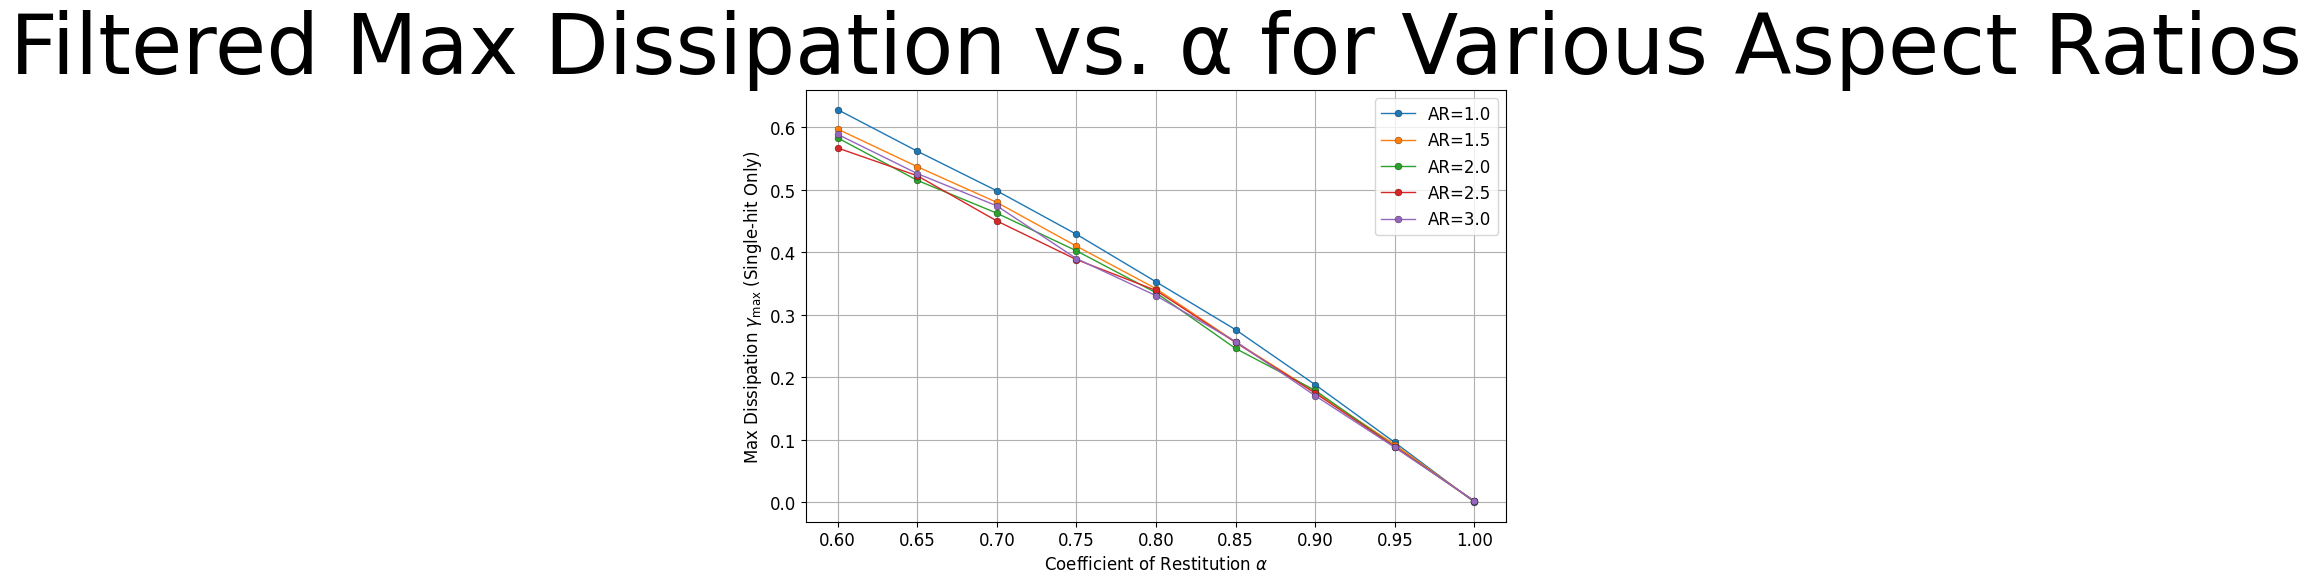

In [60]:
root_dir = "/home/muhammed/Documents/Thesis/New Simulations/Alpha"
alpha_vals2, gamma_matrix2 = plot_all_ARs_filtered(root_dir)

In [61]:
def print_delta_eps_max_dict(root_dir):
    AR_dirs = ['10', '15', '20', '25', '30']
    AR_vals = [int(ar)/10.0 for ar in AR_dirs]

    alpha_dirs = sorted([d for d in os.listdir(root_dir)
                         if os.path.isdir(os.path.join(root_dir, d)) and d.isdigit()],
                         key=lambda x: int(x))
    alpha_vals = [int(a)/100.0 for a in alpha_dirs]

    delta_dict = {}

    for AR_dir, AR_val in zip(AR_dirs, AR_vals):
        delta_dict[AR_val] = {}
        for alpha_dir, alpha_val in zip(alpha_dirs, alpha_vals):
            folder_path = os.path.join(root_dir, alpha_dir, AR_dir)
            if os.path.exists(os.path.join(folder_path, "Ef.txt")):
                delta = load_and_process_Edata_filtered(folder_path)
                delta_dict[AR_val][alpha_val] = float(delta)
            else:
                delta_dict[AR_val][alpha_val] = None

    # ---- Pretty print ----
    print("\nDelta_epsilon_max dictionary:\n")
    for AR in sorted(delta_dict.keys()):
        print(f"AR = {AR:.1f}")
        for alpha in sorted(delta_dict[AR].keys()):
            val = delta_dict[AR][alpha]
            if val is None:
                print(f"  alpha = {alpha:.2f} : MISSING")
            else:
                print(f"  alpha = {alpha:.2f} : {val:.8f}")
        print()

    return delta_dict

In [62]:
root_dir = "/home/muhammed/Documents/Thesis/New Simulations/Alpha"
delta_eps_max_dict = print_delta_eps_max_dict(root_dir)


Delta_epsilon_max dictionary:

AR = 1.0
  alpha = 0.60 : 0.62843237
  alpha = 0.65 : 0.56188775
  alpha = 0.70 : 0.49842757
  alpha = 0.75 : 0.42885752
  alpha = 0.80 : 0.35272744
  alpha = 0.85 : 0.27604604
  alpha = 0.90 : 0.18801014
  alpha = 0.95 : 0.09553369
  alpha = 1.00 : 0.00002937

AR = 1.5
  alpha = 0.60 : 0.59730676
  alpha = 0.65 : 0.53706389
  alpha = 0.70 : 0.47991723
  alpha = 0.75 : 0.40989182
  alpha = 0.80 : 0.34176128
  alpha = 0.85 : 0.25641905
  alpha = 0.90 : 0.17630623
  alpha = 0.95 : 0.09206433
  alpha = 1.00 : 0.00107540

AR = 2.0
  alpha = 0.60 : 0.58311891
  alpha = 0.65 : 0.51520812
  alpha = 0.70 : 0.46263179
  alpha = 0.75 : 0.40238170
  alpha = 0.80 : 0.33524739
  alpha = 0.85 : 0.24599273
  alpha = 0.90 : 0.17893030
  alpha = 0.95 : 0.08893593
  alpha = 1.00 : 0.00157158

AR = 2.5
  alpha = 0.60 : 0.56700614
  alpha = 0.65 : 0.52261793
  alpha = 0.70 : 0.45015398
  alpha = 0.75 : 0.38835223
  alpha = 0.80 : 0.33890285
  alpha = 0.85 : 0.25566058
  alp

In [63]:
import os
import numpy as np
import matplotlib.pyplot as plt

def compute_one_hit_ratio(nphit_path):
    """Reads NPhit.txt and computes the ratio of 1-hit rows to total hits."""
    try:
        nphit = np.loadtxt(nphit_path, dtype=int)
        total_hits = np.sum(nphit)
        one_hit_rows = np.sum(nphit == 1)
        return one_hit_rows / total_hits if total_hits > 0 else np.nan
    except Exception as e:
        print(f"Failed to process {nphit_path}: {e}")
        return None

def plot_one_hit_ratios(root_dir):
    AR_dirs = ['10','15', '20', '25', '30']
    AR_vals = [int(ar)/10.0 for ar in AR_dirs]

    alpha_dirs = sorted([d for d in os.listdir(root_dir)
                         if os.path.isdir(os.path.join(root_dir, d)) and d.isdigit()],
                         key=lambda x: int(x))

    alpha_vals = [int(a)/100.0 for a in alpha_dirs]
    one_hit_matrix = []

    fig,ax = plt.subplots();
    markers = ['o', '^', 'v', 's', 'D', 'X', '*']
    i = 0
    for AR_dir, AR_val in zip(AR_dirs, AR_vals):
        ratios = []
        for alpha_dir in alpha_dirs:
            nphit_path = os.path.join(root_dir, alpha_dir, AR_dir, "NPhit.txt")
            if os.path.exists(nphit_path):
                ratio = compute_one_hit_ratio(nphit_path)
                ratios.append(ratio)
            else:
                ratios.append(np.nan)
        one_hit_matrix.append(ratios)
        ax.scatter(alpha_vals, ratios, marker=markers[i], color=colors[i], label=fr'{AR_val}', zorder=3)
        i+=1

    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'Pr(1-hit)')
    ax.legend()
    plt.show()

    return alpha_vals, AR_vals, one_hit_matrix

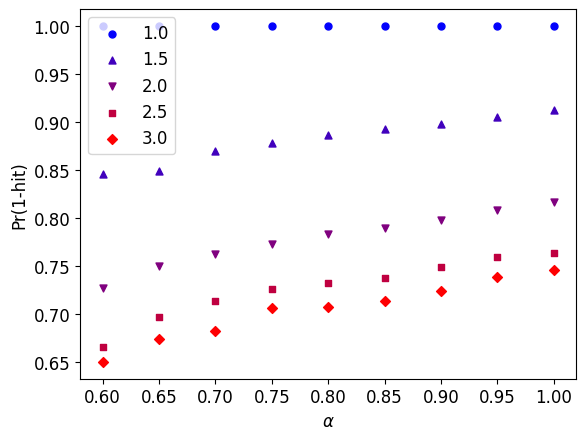

In [64]:
root_dir = "/home/muhammed/Documents/Thesis/New Simulations/Alpha"
alpha_vals, AR_vals, one_hit_matrix = plot_one_hit_ratios(root_dir)

In [65]:
def print_P1hit_dict(root_dir):
    AR_dirs = ['10', '15', '20', '25', '30']
    AR_vals = [int(ar)/10.0 for ar in AR_dirs]

    alpha_dirs = sorted([d for d in os.listdir(root_dir)
                         if os.path.isdir(os.path.join(root_dir, d)) and d.isdigit()],
                         key=lambda x: int(x))
    alpha_vals = [int(a)/100.0 for a in alpha_dirs]

    P1hit_dict = {}

    for AR_dir, AR_val in zip(AR_dirs, AR_vals):
        P1hit_dict[AR_val] = {}
        for alpha_dir, alpha_val in zip(alpha_dirs, alpha_vals):
            nphit_path = os.path.join(root_dir, alpha_dir, AR_dir, "NPhit.txt")
            if os.path.exists(nphit_path):
                ratio = compute_one_hit_ratio(nphit_path)
                P1hit_dict[AR_val][alpha_val] = float(ratio)
            else:
                P1hit_dict[AR_val][alpha_val] = None

    # ---- Pretty print ----
    print("\nP_1hit(alpha, AR) dictionary:\n")
    for AR in sorted(P1hit_dict.keys()):
        print(f"AR = {AR:.1f}")
        for alpha in sorted(P1hit_dict[AR].keys()):
            val = P1hit_dict[AR][alpha]
            if val is None:
                print(f"  alpha = {alpha:.2f} : MISSING")
            else:
                print(f"  alpha = {alpha:.2f} : {val:.6f}")
        print()

    return P1hit_dict

In [66]:
root_dir = "/home/muhammed/Documents/Thesis/New Simulations/Alpha"
P1hit_dict = print_P1hit_dict(root_dir)


P_1hit(alpha, AR) dictionary:

AR = 1.0
  alpha = 0.60 : 1.000000
  alpha = 0.65 : 1.000000
  alpha = 0.70 : 1.000000
  alpha = 0.75 : 1.000000
  alpha = 0.80 : 1.000000
  alpha = 0.85 : 1.000000
  alpha = 0.90 : 1.000000
  alpha = 0.95 : 1.000000
  alpha = 1.00 : 1.000000

AR = 1.5
  alpha = 0.60 : 0.845749
  alpha = 0.65 : 0.849408
  alpha = 0.70 : 0.869413
  alpha = 0.75 : 0.878642
  alpha = 0.80 : 0.886644
  alpha = 0.85 : 0.892894
  alpha = 0.90 : 0.897983
  alpha = 0.95 : 0.904753
  alpha = 1.00 : 0.912958

AR = 2.0
  alpha = 0.60 : 0.727508
  alpha = 0.65 : 0.749936
  alpha = 0.70 : 0.762986
  alpha = 0.75 : 0.773066
  alpha = 0.80 : 0.783317
  alpha = 0.85 : 0.789631
  alpha = 0.90 : 0.798194
  alpha = 0.95 : 0.808411
  alpha = 1.00 : 0.817125

AR = 2.5
  alpha = 0.60 : 0.665665
  alpha = 0.65 : 0.697077
  alpha = 0.70 : 0.713907
  alpha = 0.75 : 0.725973
  alpha = 0.80 : 0.732115
  alpha = 0.85 : 0.737128
  alpha = 0.90 : 0.748857
  alpha = 0.95 : 0.759017
  alpha = 1.00 : 0.

In [46]:
import numpy as np
import os

def load_and_fix_inputs():
    # Load the raw energy file directly
    # format: [E_tr, E_r1, E_r2, ...]
    path = "/home/muhammed/Documents/Thesis/New Simulations/GMM/AR20/r05/Ef.txt" 
    data = np.loadtxt(path)
    
    # Calculate Pre-collision Totals
    E_tr_tot = data[:, 0] + data[:, 1] + data[:, 2] # If columns are velocity components?
    # WAIT: Your loader says E_data cols 0,1,2 are Pre-energies.
    # Col 0: Trans, Col 1: Rot1, Col 2: Rot2
    
    E_total_pre = data[:, 0] + data[:, 1] + data[:, 2]
    E_rot_pre   = data[:, 1] + data[:, 2]
    
    # Calculate Epsilons (The inputs to GMM)
    epsilon_tr = data[:, 0] / E_total_pre
    epsilon_r1 = data[:, 1] / E_rot_pre
    
    # Validation
    if np.any(epsilon_tr > 1.0) or np.any(epsilon_r1 > 1.0):
        print("Error: Values > 1.0 detected!")
    else:
        print("Data is valid (0-1). Saving...")
        
    # Save columns: [epsilon_tr, epsilon_r1]
    valid_inputs = np.column_stack((epsilon_tr, epsilon_r1))
    np.savetxt("inputs_r05.txt", valid_inputs, fmt='%.8e')

load_and_fix_inputs()

Data is valid (0-1). Saving...


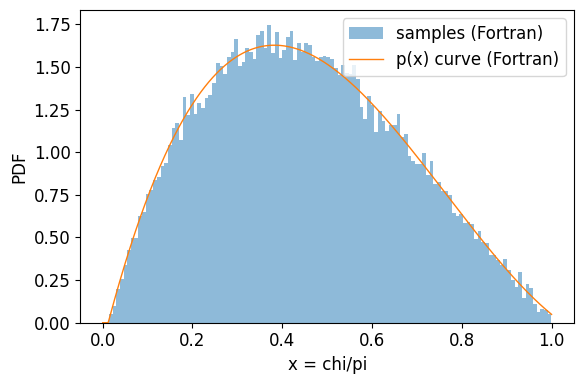

In [93]:
import numpy as np
import matplotlib.pyplot as plt

x_samp = np.loadtxt("chi_samples.txt")          # x in [0,1]
x_curve, p_curve = np.loadtxt("pchi_curve.txt").T

plt.figure(figsize=(6,4))
plt.hist(x_samp, bins=120, density=True, alpha=0.5, label="samples (Fortran)")
plt.plot(x_curve, p_curve/np.trapz(p_curve, x_curve), label="p(x) curve (Fortran)")
plt.xlabel("x = chi/pi")
plt.ylabel("PDF")
plt.legend()
plt.tight_layout()
plt.show()

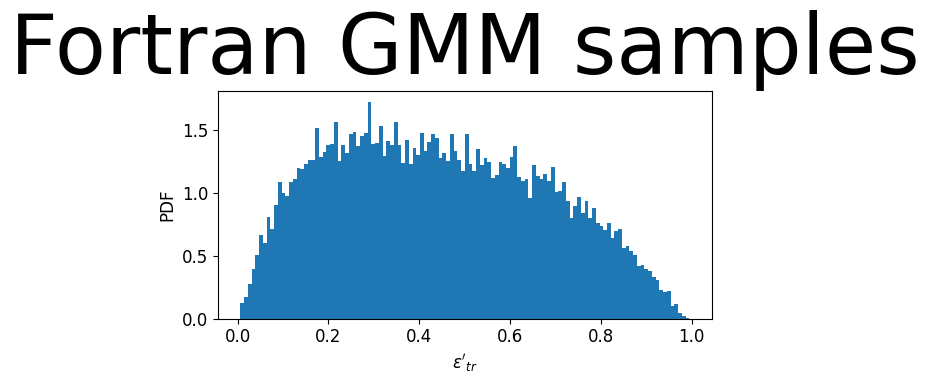

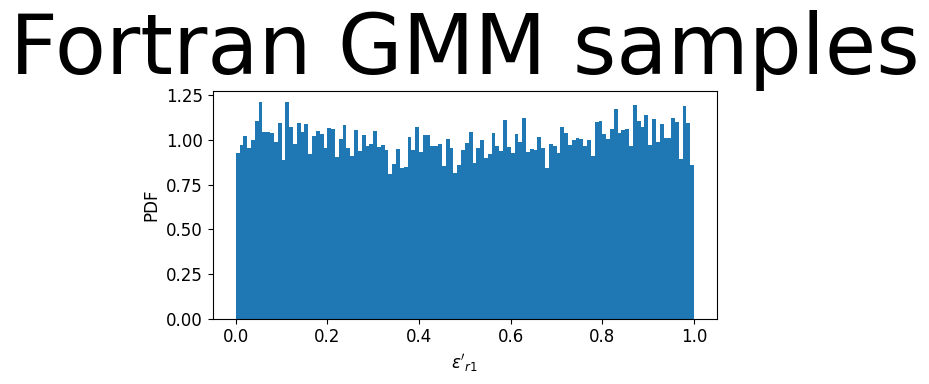

In [94]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("validation_output.txt")
r, e_tr, e_r1, e_tr_p, e_r1_p = data.T

plt.figure(figsize=(6,4))
plt.hist(e_tr_p, bins=120, density=True)
plt.xlabel(r"$\epsilon'_{tr}$")
plt.ylabel("PDF")
plt.title("Fortran GMM samples")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(e_r1_p, bins=120, density=True)
plt.xlabel(r"$\epsilon'_{r1}$")
plt.ylabel("PDF")
plt.title("Fortran GMM samples")
plt.tight_layout()
plt.show()

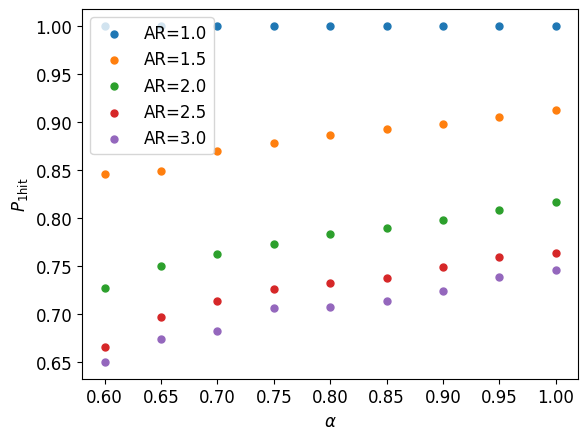

In [95]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("p1hit_table.txt")
AR, alpha, P1 = data.T

for ar in sorted(set(AR)):
    mask = AR == ar
    plt.scatter(alpha[mask], P1[mask], label=f"AR={ar}")

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$P_{1\mathrm{hit}}$")
plt.legend()
plt.show()

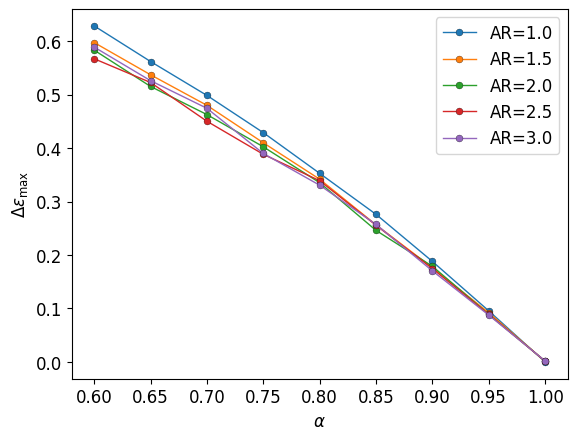

In [96]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("delta_eps_max_table.txt")
AR, alpha, dmax = data.T

for ar in sorted(set(AR)):
    mask = AR == ar
    plt.plot(alpha[mask], dmax[mask], '-o', label=f"AR={ar}")

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\Delta\epsilon_{\max}$")
plt.legend()
plt.show()